In [40]:
%matplotlib inline

import os, sys, json, warnings, time
warnings.filterwarnings("ignore")

from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import average_precision_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.metrics import AUC

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

f"Tensor version: {tf.__version__}"

'Tensor version: 2.20.0'

Pfade definieren

In [4]:
# ---------- Paths ----------
if "__file__" in globals():
    ROOT = Path(__file__).resolve().parents[1]
else:
    ROOT = Path.cwd() if Path.cwd().name not in ("notebooks","tools","tests") else Path.cwd().parent

REPORTS_IN  = Path(os.getenv("REPORTS_IN")  or (ROOT / "reports"))         # shared inputs (split, features)
REPORTS_OUT = Path(os.getenv("REPORTS_OUT") or (ROOT / "reports_Charly/NN_embedded"))   
REPORTS_OUT.mkdir(parents=True, exist_ok=True)

# import loading method
sys.path.insert(0, str(ROOT))
from src.data_loader import load_and_save_data

Speed-Profile erstellen für die Berechnung der Modelle

In [7]:
# ---------- Speed/Profile ----------
# von Lucas übernommen, können zwar nicht alle auf NN angewendet werden, aber zum Teil
SPEED = os.getenv("SPEED", "MEDIUM").upper().strip()
def speed_cfg():
    cfg = dict(CV=5, N_EST=6000, EARLY_STOP=200, MODELS=["lgbm","xgb"], LR=0.03)
    if SPEED == "FAST":
        cfg.update(CV=3, N_EST=2000, EARLY_STOP=50, MODELS=["lgbm"], LR=0.05)
    elif SPEED == "MEDIUM":
        cfg.update(CV=5, N_EST=4000, EARLY_STOP=100)
    elif SPEED == "FULL":
        cfg.update(CV=5, N_EST=8000, EARLY_STOP=300)
    return cfg

CFG        = speed_cfg()
RND        = int(os.getenv("RND", "42"))
CV         = int(os.getenv("CV", str(CFG["CV"])))
N_EST      = int(os.getenv("N_EST", str(CFG["N_EST"])))
ESR        = int(os.getenv("EARLY_STOP", str(CFG["EARLY_STOP"])))
MODELS     = [m.strip() for m in os.getenv("MODELS", ",".join(CFG["MODELS"])).split(",") if m.strip()]
IMB        = os.getenv("IMB", "spw").lower()  
LR         = float(os.getenv("LR", str(CFG["LR"])))
MEMBER     = os.getenv("MEMBER", "Charlotte")

Load the Dataset

In [8]:
# Laden des Datensatzes und alle -1 durch nan ersetzen, da das ML nicht mit nans umgehen kann
data = load_and_save_data().replace(np.nan, -1)

# zur Kontrolle
total_nans = data.isna().sum().sum()
print("total nans: ",total_nans)


Loading dataset from local file: C:\Users\Charlotte Schmid\Nextcloud\Uni\Advanced Data Analytics\Projekt\ada_portoSeguro\data\raw\porto_seguro_safe_driver_prediction.csv
Dataset loaded successfully.
total nans:  0


Strukturierung des Datensatzes von Lucas
Es gibt vier verschiedene Modelle, die wir miteinander vergleichen: 
- drop_calc+opt+extras,37
- drop_calc+extras,39 
- drop_calc_only,37
- all_features,57

Entscheidung: alle ps_calc_* droppen (drop_calc_only),missing_count und sum_all_bin hinzufügen (drop_calc+extras),  zusätzlich ps_ind_14 und ps_car_10_cat droppen (drop_calc+opt+extras) 


In [25]:
# ---------- Utils ----------
# Variablen nach Skalenniveau sortieren
def split_cols(cols):
    cat = [c for c in cols if str(c).endswith("_cat")]
    bin = [c for c in cols if str(c).endswith("_bin")]
    num  = [c for c in cols if c not in cat and c not in bin and c != "target"]
    return cat, bin, num

# Extra-variablen erstellen
def fe_extras(X, selected):
    X = X.copy()
    if "missing_count" in selected:
        X["missing_count"] = X.isna().sum(axis=1)
    if "sum_all_bin" in selected:
        b = [c for c in X.columns if str(c).endswith("_bin")]
        X["sum_all_bin"] = X[b].sum(axis=1) if b else 0
    return X

# Datensatz mit ausgewählten Spalten erstellen
def load_selected_feature_list():
    f = REPORTS_IN / "features_selected.csv"
    if not f.exists():
        raise FileNotFoundError(f"Missing {f}. Run feature-gate first.")
    s = pd.read_csv(f)
    if "raw_feature" not in s.columns:
        raise ValueError("features_selected.csv must have column 'raw_feature'.")
    return s["raw_feature"].astype(str).tolist()

var_selected = load_selected_feature_list() # 35 Original-Features

# Originalspalten für das Model auswählen nach PCA
X_temp = data[var_selected[:-2]]  # alles von Anfang bis zweitletzte Spalte
var_cat, var_bin, var_num = split_cols(X_temp.columns)

# Extra-Features erstellen
X = fe_extras(data, var_selected)

# kompletten Datensatz für drop_calc+opt+extras erstellen
X = X[var_selected]
y = data["target"]

# zusätzliche Features der Kategorie var_num hinzufügen 
var_num.append("missing_count")
var_num.append("sum_all_bin")


X.shape, y.shape


((595212, 37), (595212,))

In [ ]:
# zur Kontrolle
print(var_cat) # 13 Variablen
print(var_num) # 13 Variablen
print(var_bin) # 11 Variablen

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_11_cat']
['ps_ind_01', 'ps_ind_03', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'missing_count', 'sum_all_bin']
['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


Train-Test Split

In [28]:
## Split von split_indices übernommen: 
split_p = REPORTS_IN / "split_indices.json"
split = json.loads(split_p.read_text())

# Datensatz aufsplitten nach der json-Datei
X_train = X.loc[split["train"]]
y_train = y.loc[split["train"]]
X_test = X.loc[split["test"]]
y_test = y.loc[split["test"]]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((200000, 37), (200000,), (50000, 37), (50000,))

### Pre-Processing

Aus der EDA kennen wir die einzelne Variablen. 
- es müssen fehlende Werte ersetzt werden
- es gibt einige kategoriale Variablen mit sehr vielen kategorien diese werden jedoch jetzt ebenfalls mit One-Hot Encoding enkodiert, um 
- Standardisierung der numerischen Variablen

In [29]:
# Sortieren der kategorialen  Variablen nach vielen und wenigen Kategorien
small_cat = [col for col in var_cat if data[col].nunique() < 10]
large_cat = [col for col in var_cat if data[col].nunique() >= 10]
small_cat,large_cat

(['ps_ind_02_cat',
  'ps_ind_04_cat',
  'ps_ind_05_cat',
  'ps_car_02_cat',
  'ps_car_03_cat',
  'ps_car_05_cat',
  'ps_car_07_cat',
  'ps_car_08_cat',
  'ps_car_09_cat'],
 ['ps_car_01_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_11_cat'])

In [30]:
# Pipeline für numerische Features
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline für kleine kategoriale Features
cat_small_pipeline = Pipeline([
    # kein Imputer, da -1 jetzt als eigene Kategorie mit einbezogen wird
    ("onehot", OneHotEncoder(sparse_output=False, drop='first', handle_unknown="ignore"))
])

# Pipeline für binäre Features
bin_pipeline = Pipeline([
    # bei binären Variablen wird die häufigste Kategorie gewählt, damit sie binär bleiben und keine 3. Kategorie dazu kommt
    ("impute", SimpleImputer(strategy="most_frequent", missing_values=-1))
])

ps_preprocessor = ColumnTransformer([
    ("var_num", num_pipeline, var_num),
    ("small_cat", cat_small_pipeline, small_cat),
    ("var_bin", bin_pipeline, var_bin)
])

ps_preprocessor

,transformers,"[('var_num', ...), ('small_cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [31]:
# Transformieren der Daten
X_processed_train = ps_preprocessor.fit_transform(X_train)
X_processed_test = ps_preprocessor.fit_transform(X_test)

# große Kategoriale Variablen
X_large_train = X_train[large_cat]
X_large_test = X_test[large_cat]

print(X_processed_train.shape, X_large_train.shape, y_train.shape, X_processed_test.shape, X_large_test.shape, y_test.shape)

# umwandlen von x_large in numpay array, da noch dataframe
X_large_train = X_large_train.to_numpy()
X_large_test = X_large_test.to_numpy()

# überprüfen der Datentypen
print(type(X_processed_train), type(X_processed_test))
print(type(X_large_test), type(X_large_train))
print(type(y_train), type(y_test))


(200000, 51) (200000, 4) (200000,) (50000, 51) (50000, 4) (50000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


Model Setup

In [ ]:
# Model als Funktion definieren, um Kreuzvalidierung durchführen zu können
def create_model(input_processed, input_large_raw, embedding_dim =8, dropout_rate=0.2, learning_rate = 0.001):
    inputs_preprocessed = Input(shape=(input_processed,), name = "Preprocessed_input")
    inputs_large = []
    embeddings = []

    # Embeddings für jede Spalte der großen Variablen bestimmen
    for i, variable in enumerate(input_large_raw):
        inp = Input(shape=(1,), dtype = tf.int32, name =f"cat_input_{i}")
        emb = Flatten()(Embedding(
            input_dim = variable,
            output_dim=embedding_dim
        )(inp))
        inputs_large.append(inp)
        embeddings.append(emb)
    
    # Alles zuEmbeddings und vorbereitete Features zusammenführen
    x = Concatenate() ([inputs_preprocessed] + embeddings)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x) 
    output = Dense(1,activation='sigmoid')(x)

    # Optimizer mit eigener Lernrate definieren
    optimizer = Adam(learning_rate = learning_rate)

    # Model kompilieren
    model = Model(inputs = [inputs_preprocessed] + inputs_large, outputs = output)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name="auc")]) 
    return model

Model Training

In [47]:
# Input-Daten in eine Liste packen
train_inputs = [X_processed_train] + [X_large_train[:, i:i+1] for i in range(X_large_train.shape[1])]
test_inputs  = [X_processed_test]  + [X_large_test[:, i:i+1]  for i in range(X_large_test.shape[1])]

# Modeldefinieren
model_base = create_model(
    X_processed_train.shape[1],
    [int(np.max(X_large_train[:, i])) + 1 for i in range(X_large_train.shape[1])], 
    embedding_dim=8,
    dropout_rate=0.2, 
    learning_rate = 0.001
    )

# Parameter definieren
epochs = 10
early_stop = EarlyStopping(monitor='val_auc', mode = "max",patience=4, restore_best_weights=True)

# Zeit messen
start = time.perf_counter()

# Modell trainieren
history_base = model_base.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=epochs, 
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.9634 - auc: 0.5751 - loss: 0.1605 - val_accuracy: 0.9634 - val_auc: 0.6314 - val_loss: 0.1529
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9634 - auc: 0.6005 - loss: 0.1560 - val_accuracy: 0.9634 - val_auc: 0.6358 - val_loss: 0.1528
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9634 - auc: 0.6098 - loss: 0.1549 - val_accuracy: 0.9634 - val_auc: 0.6375 - val_loss: 0.1527
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9634 - auc: 0.6154 - loss: 0.1542 - val_accuracy: 0.9634 - val_auc: 0.6384 - val_loss: 0.1526
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9634 - auc: 0.6236 - loss: 0.1536 - val_accuracy: 0.9634 - val_auc: 0.6285 - val_loss: 0.1541
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9634 - auc: 0.6281 - loss: 0.1532 - val_accuracy: 0.9634 - val_auc: 0.6305 - val_loss: 0.1532
Epoch 7/10
6250/6250 ━━━━━━

Grafiken für Trainingsverlauf
- Trainings- und Validierungs-Loss
- Accuracy

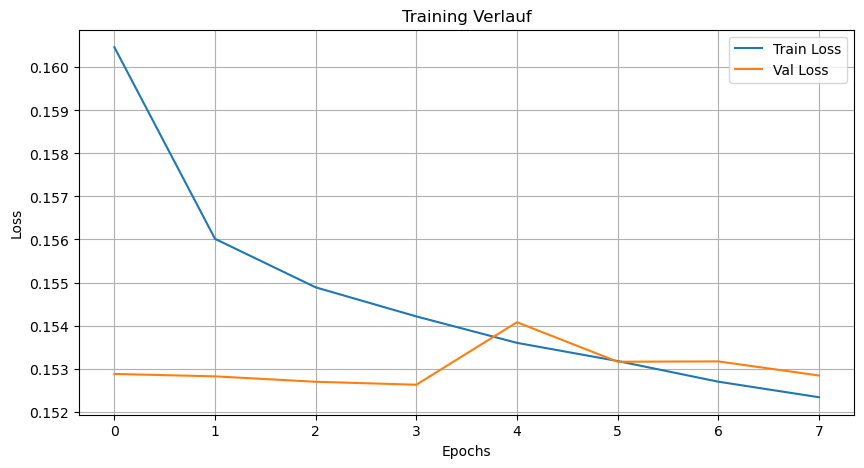

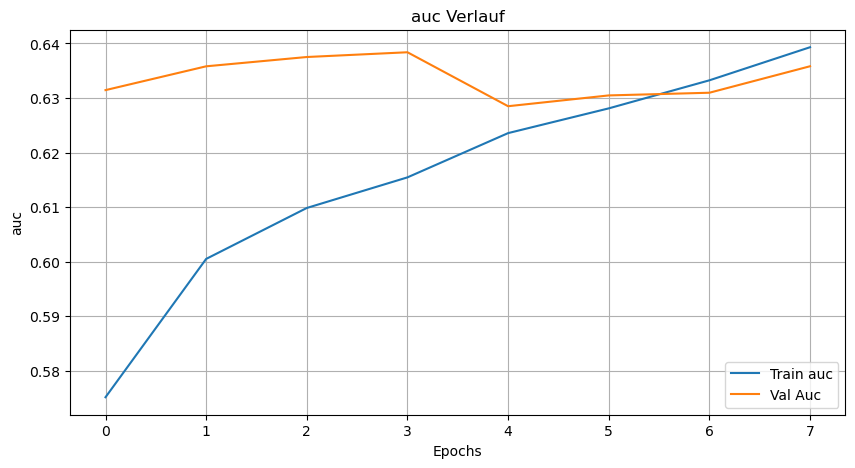

In [49]:
# Trainings- und Validierungs-Loss
plt.figure(figsize=(10,5))
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Verlauf')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(REPORTS_OUT/"plot_train_loss.png", dpi=150); plt.close()

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history_base.history['auc'], label='Train auc')
plt.plot(history_base.history['val_auc'], label='Val Auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.title('auc Verlauf')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(REPORTS_OUT/"plot_accuracy.png", dpi=150); plt.close()


Hyperparameter optimieren:
- müsste als nächster Schritt noch durchgeführt werden

In [ ]:
param_dist = {
    'embedding_dim': [4, 8, 16],
    'neurons': [32, 64],
    'dropout': [0.1, 0.2],
    'batch_size': [32, 64],
    'learning_rate': [0.001, 0.01, 0.0001]
}

Vergleichsmetriken berechnen
- Crossvalidation
- Holdout
- Time

Durchführung der Kreuzvalidierung

In [52]:
skf = StratifiedKFold(n_splits=CV, shuffle=True, random_state=RND)
#skf = StratifiedKFold(n_splits =5, shuffle = True, random_state =RND)

auc_scores = []
ap_scores = []

# Input-Dimensionen vorbereiten
input_processed = X_processed_train.shape[1]
input_large = [int(np.max(X_large_train[:, i])) + 1 for i in range(X_large_train.shape[1])]


for train_idx, val_idx in skf.split(X_processed_train, y_train):
    # der Trainingsdatensatz wird in Trainings- und Validierungsteildatensatz gesplittet:
    X_processed_tr, X_processed_val = X_processed_train[train_idx], X_processed_train[val_idx]
    X_large_tr, X_large_val =  X_large_train[train_idx], X_large_train[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Inputs für Keras vorbereiten
    train_inputs = [X_processed_tr] + [X_large_tr[:, i:i+1] for i in range(X_large_tr.shape[1])]
    val_inputs =  [X_processed_val] + [X_large_val[:, i:i+1] for i in range(X_large_val.shape[1])]

    # Neues Model pro Fold erstellen
    model_cv = create_model(input_processed, input_large, embedding_dim=8, dropout_rate=0.2, 
        learning_rate = 0.001)

    # Early Stopping
    early_stop = EarlyStopping(monitor="val_auc", mode = "max", patience=4, restore_best_weights=True)
    
    # Trainieren der Modelle
    model_cv.fit(
        train_inputs, y_tr,
        validation_data = (val_inputs, y_val),
        epochs = 20, 
        batch_size = 32, 
        callbacks = [early_stop],
        verbose = 0
    )

    # Vorhersagen (Wahrscheinlichkeiten)
    y_val_pred = model_cv.predict(val_inputs, verbose=0).ravel()

    # Metriken
    auc_scores.append(roc_auc_score(y_val, y_val_pred))
    ap_scores.append(average_precision_score(y_val, y_val_pred))

# Ergebnisse
cv_auc_mean = np.mean(auc_scores)
cv_ap_mean = np.mean(ap_scores)

#best_model = max(baselines.items(), key=lambda kv: kv[1]["pr_auc"])[0]

print("CV AUC mean:", cv_auc_mean)
print("CV AP mean:", cv_ap_mean)

CV AUC mean: 0.6253706940104031
CV AP mean: 0.06155676580775572


Genauigkeit mit dem Testdatensatz überprüfen

In [53]:
# Holdout mit bisher nicht genutzten Testdaten

model_holdout = create_model(input_processed, input_large, embedding_dim = 8, dropout_rate=0.2, learning_rate = 0.001)

early_stop = EarlyStopping(monitor="val_auc", mode = "max", patience=4, restore_best_weights=True)

model_holdout.fit(
    [X_processed_train] + [X_large_train[:, i:i+1] for i in range(X_large_train.shape[1])],
    y_train,
    validation_split=0.1,   # kleiner Teil für val_auc Monitoring
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Vorhersagen auf Holdout_Testset
y_pred_proba = model_holdout.predict(test_inputs, verbose=0).ravel()

# Metriken berechnen
hold_auc = roc_auc_score(y_test, y_pred_proba)
hold_ap = average_precision_score(y_test, y_pred_proba)
hold_brier = brier_score_loss(y_test, y_pred_proba)

print("Holdout AUC:", hold_auc)
print("Holdout AP:", hold_ap)
print("Holdout Brier Score:", hold_brier)

Epoch 1/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9633 - auc: 0.5790 - loss: 0.1603 - val_accuracy: 0.9610 - val_auc: 0.6008 - val_loss: 0.1621
Epoch 2/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9637 - auc: 0.5981 - loss: 0.1558 - val_accuracy: 0.9610 - val_auc: 0.6032 - val_loss: 0.1653
Epoch 3/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9637 - auc: 0.6092 - loss: 0.1543 - val_accuracy: 0.9610 - val_auc: 0.6094 - val_loss: 0.1630
Epoch 4/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9637 - auc: 0.6140 - loss: 0.1537 - val_accuracy: 0.9610 - val_auc: 0.6132 - val_loss: 0.1614
Epoch 5/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9637 - auc: 0.6227 - loss: 0.1529 - val_accuracy: 0.9610 - val_auc: 0.6068 - val_loss: 0.1646
Epoch 6/50
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9637 - auc: 0.6277 - loss: 0.1525 - val_accuracy: 0.9610 - val_auc: 0.6072 - val_loss: 0.1619
Epoch 7/50
5625/5625 ━

Zeitmessung

In [54]:
# Zeitmetriken berechnen
fit_time_s = time.perf_counter() - start

# Vorhersagezeit auf 1000 Samples selbst berechnen, da keine eigene Metrik vorhanden
X_large_sample = X_large_test[:1000]
sample_inputs = [X_processed_test[:1000]] + [X_large_sample[:, i:i+1] for i in range(X_large_sample.shape[1])]

start_1000 = time.perf_counter()
_ = model_base.predict(sample_inputs, verbose=0)
elapsed = (time.perf_counter() - start_1000) * 1000  # in ms
predict_time_ms_per_1k = elapsed

print("Fit time (s):", fit_time_s)
print("Predict time (ms/1k):", predict_time_ms_per_1k)

Fit time (s): 1612.5414301999845
Predict time (ms/1k): 795.523300068453


In [55]:
# beste Epoche (Epoche mit bestem Wert äquivalent zu best_iteration)
best_iteration = early_stop.stopped_epoch - early_stop.patience

print("Best iteration:", best_iteration)

Best iteration: 3


Zusammenfassung der Berichte

In [56]:
# save predictions
pd.DataFrame({"proba": y_pred_proba, "y_true": y_test.values}).to_csv(REPORTS_OUT/"holdout_preds.csv", index=False)

# save metrics
row = {
    "member": MEMBER,
    "model_name": "NN_embedded",
    "encoder": "OneHotEncoder and Embeddings for large categories",
    "split_path": str(split_p),  # das macht hier noch nicht so richtig Sinn
    "feature_recipe": "selected_from_feature_gate",
    "seed": RND, "cv_folds": CV,
    "hold_auc": hold_auc, "hold_ap": hold_ap, "hold_brier": hold_brier,
    "cv_auc_mean": cv_auc_mean, "cv_ap_mean": cv_ap_mean,
    "early_stopping": True,
    "best_iteration": best_iteration,
    "n_trees": (epochs, "Epochs"),
    "fit_time_s": fit_time_s,
    "predict_time_ms_per_1k": predict_time_ms_per_1k,
    "params_json": None, #json.dumps(best_params),
}

out_csv = REPORTS_OUT/"team_model_summary.csv"
pd.DataFrame([row]).to_csv(out_csv, mode="a", index=False, header=not out_csv.exists())

Grafiken erstellen
- ohne Feature Importance

In [57]:
def save_pr_curve(y_test, proba, out_path):
    import matplotlib.pyplot as plt
    prec, rec, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.figure(figsize=(7,5))
    plt.plot(rec, prec, label=f'AP={ap:.4f}')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall')
    plt.xlim([0,1]); plt.ylim([0,1]); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close()

def save_calibration(y_test, proba, out_path):
    import matplotlib.pyplot as plt
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=20, strategy="quantile")
    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1],'--',label='Perfect')
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.xlabel('Predicted'); plt.ylabel('Observed'); plt.title('Calibration')
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close()


save_pr_curve(y_test.values, y_pred_proba, REPORTS_OUT/"plot_pr.png")
save_calibration(y_test.values, y_pred_proba, REPORTS_OUT/"plot_calibration.png")